In [2]:
FILE_PATH = "../../data/superstore_dataset.csv"

In [3]:
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings

# for later exploration
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [5]:
sales_raw = pd.read_csv(FILE_PATH)
sales_raw.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2020-152156,11/8/2020,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2020-152156,11/8/2020,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2020-138688,6/12/2020,6/16/2020,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2019-108966,10/11/2019,10/18/2019,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2019-108966,10/11/2019,10/18/2019,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
sales_raw.info()
sales_raw.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          9994 non-null   int64  
 1   Order ID        9994 non-null   object 
 2   Order Date      9994 non-null   object 
 3   Ship Date       9994 non-null   object 
 4   Ship Mode       9994 non-null   object 
 5   Customer ID     9994 non-null   object 
 6   Customer Name   9994 non-null   object 
 7   Segment         9994 non-null   object 
 8   Country/Region  9994 non-null   object 
 9   City            9994 non-null   object 
 10  State           9994 non-null   object 
 11  Postal Code     9983 non-null   float64
 12  Region          9994 non-null   object 
 13  Product ID      9994 non-null   object 
 14  Category        9994 non-null   object 
 15  Sub-Category    9994 non-null   object 
 16  Product Name    9994 non-null   object 
 17  Sales           9994 non-null   f

<bound method NDFrame.head of       Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
0          1  CA-2020-152156   11/8/2020  11/11/2020    Second Class   
1          2  CA-2020-152156   11/8/2020  11/11/2020    Second Class   
2          3  CA-2020-138688   6/12/2020   6/16/2020    Second Class   
3          4  US-2019-108966  10/11/2019  10/18/2019  Standard Class   
4          5  US-2019-108966  10/11/2019  10/18/2019  Standard Class   
...      ...             ...         ...         ...             ...   
9989    9990  CA-2018-110422   1/21/2018   1/23/2018    Second Class   
9990    9991  CA-2021-121258   2/26/2021    3/3/2021  Standard Class   
9991    9992  CA-2021-121258   2/26/2021    3/3/2021  Standard Class   
9992    9993  CA-2021-121258   2/26/2021    3/3/2021  Standard Class   
9993    9994  CA-2021-119914    5/4/2021    5/9/2021    Second Class   

     Customer ID     Customer Name    Segment Country/Region             City  \
0       CG-12520       C

In [27]:
sales_raw.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9983.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55245.233297,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32038.715955,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,57103.000000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [28]:
sales = sales_raw.copy()
sales = sales.drop("Postal Code", axis = 1) #axis=1 for column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          9994 non-null   int64  
 1   Order ID        9994 non-null   object 
 2   Order Date      9994 non-null   object 
 3   Ship Date       9994 non-null   object 
 4   Ship Mode       9994 non-null   object 
 5   Customer ID     9994 non-null   object 
 6   Customer Name   9994 non-null   object 
 7   Segment         9994 non-null   object 
 8   Country/Region  9994 non-null   object 
 9   City            9994 non-null   object 
 10  State           9994 non-null   object 
 11  Region          9994 non-null   object 
 12  Product ID      9994 non-null   object 
 13  Category        9994 non-null   object 
 14  Sub-Category    9994 non-null   object 
 15  Product Name    9994 non-null   object 
 16  Sales           9994 non-null   float64
 17  Quantity        9994 non-null   i

In [29]:
warnings.filterwarnings('ignore')
sales['Order Date'] = pd.to_datetime(sales['Order Date'], dayfirst=True)
sales['Ship Date'] = pd.to_datetime(sales['Ship Date'], dayfirst=True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          9994 non-null   int64         
 1   Order ID        9994 non-null   object        
 2   Order Date      9994 non-null   datetime64[ns]
 3   Ship Date       9994 non-null   datetime64[ns]
 4   Ship Mode       9994 non-null   object        
 5   Customer ID     9994 non-null   object        
 6   Customer Name   9994 non-null   object        
 7   Segment         9994 non-null   object        
 8   Country/Region  9994 non-null   object        
 9   City            9994 non-null   object        
 10  State           9994 non-null   object        
 11  Region          9994 non-null   object        
 12  Product ID      9994 non-null   object        
 13  Category        9994 non-null   object        
 14  Sub-Category    9994 non-null   object        
 15  Prod

In [30]:
#Get only order date, sales, and profit
sales = sales.loc[:, ["Order Date", "Sales", "Profit"]]

#Set date column to index
sales.set_index('Order Date', inplace = True)

In [31]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9994 entries, 2020-08-11 to 2021-04-05
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   9994 non-null   float64
 1   Profit  9994 non-null   float64
dtypes: float64(2)
memory usage: 234.2 KB
None


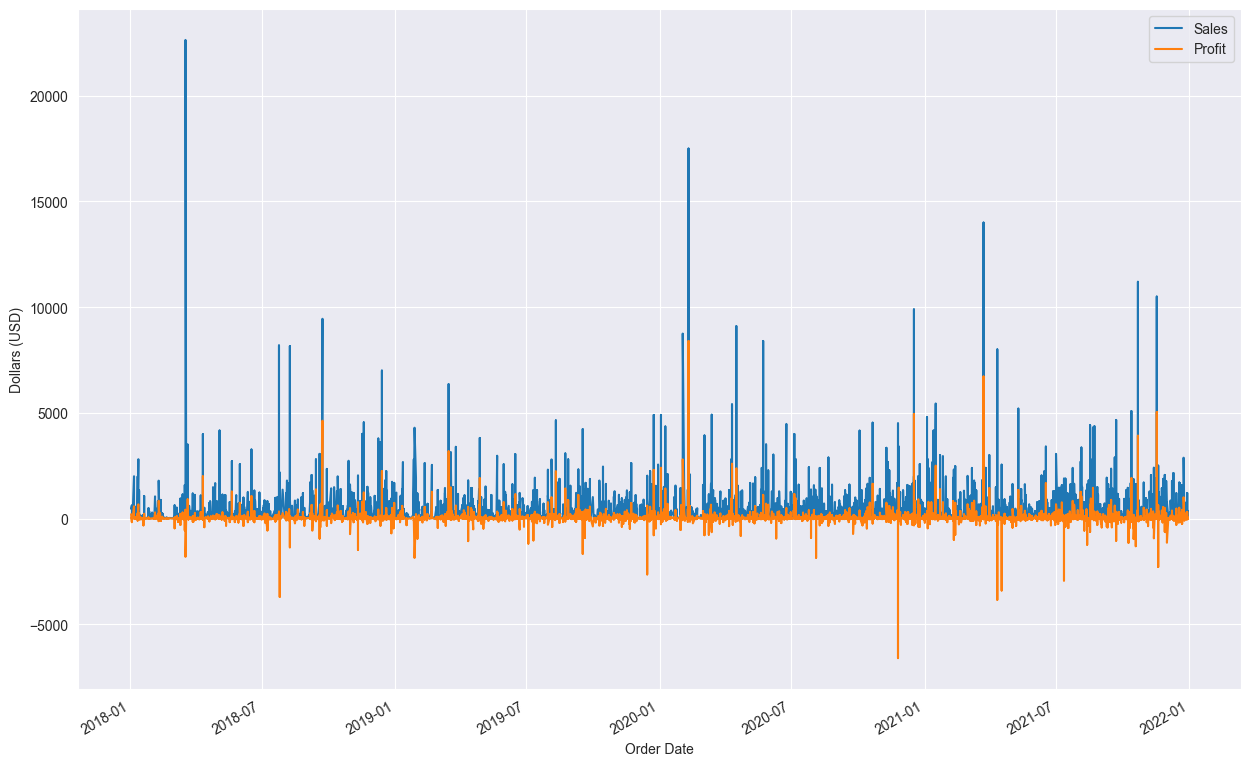

In [32]:
ax = sales.plot()
plt.gcf().set_size_inches(15, 10)
ax.set_ylabel("Dollars (USD)")
plt.show()

In [33]:
sales_by_year = pd.DataFrame()

for year in ["2018", "2019", "2020", "2021"]:
    temp_year = sales.loc[year, ["Sales"]].reset_index(drop = True)
    temp_year.rename(columns={"Sales": year}, inplace = True)
    sales_by_year = pd.concat([sales_by_year, temp_year], axis=1)

sales_by_year

,2018,2019,2020,2021
0,48.860,957.5775,261.960,15.552
1,7.280,22.3680,731.940,71.372
2,907.152,68.8100,14.620,29.472
3,18.504,2.5440,407.976,147.168
4,114.900,1044.6300,19.460,95.616
...,...,...,...,...
3307,NaN,NaN,NaN,206.100
3308,NaN,NaN,NaN,91.960
3309,NaN,NaN,NaN,258.576
3310,NaN,NaN,NaN,29.600


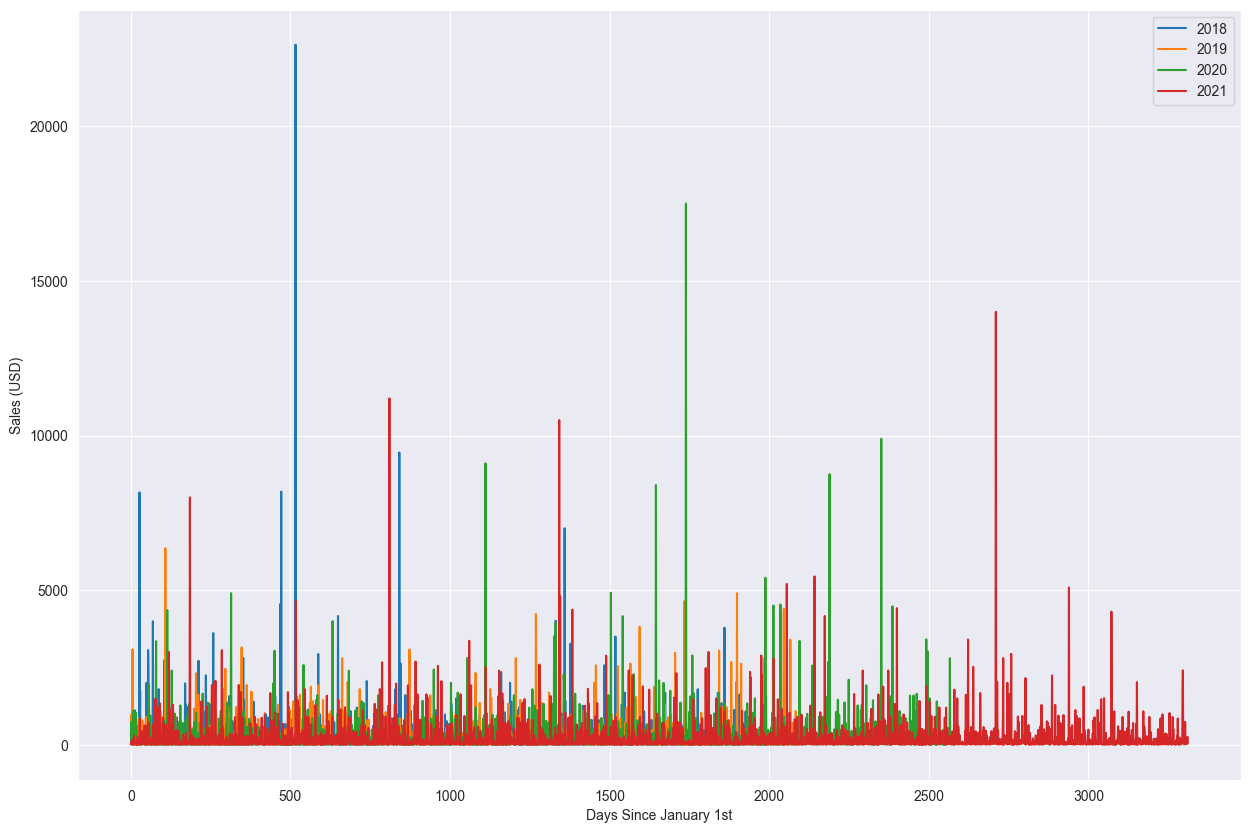

In [34]:
sales_by_year.plot()
plt.gcf().set_size_inches(15, 10)
plt.ylabel("Sales (USD)")
plt.xlabel("Days Since January 1st")
plt.show()

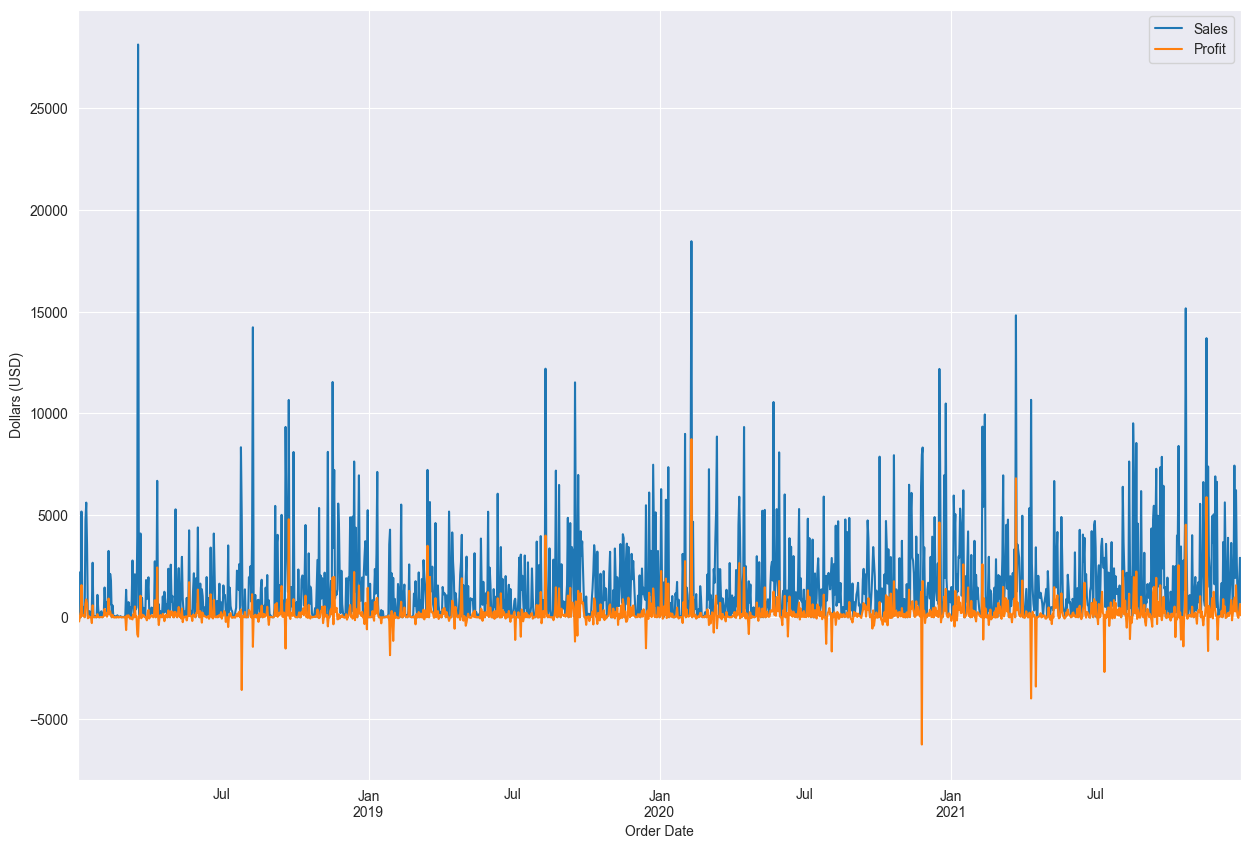

In [35]:
daily_sales = sales.groupby(pd.Grouper(freq='D')).sum()
daily_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.ylabel("Dollars (USD)")
plt.show()

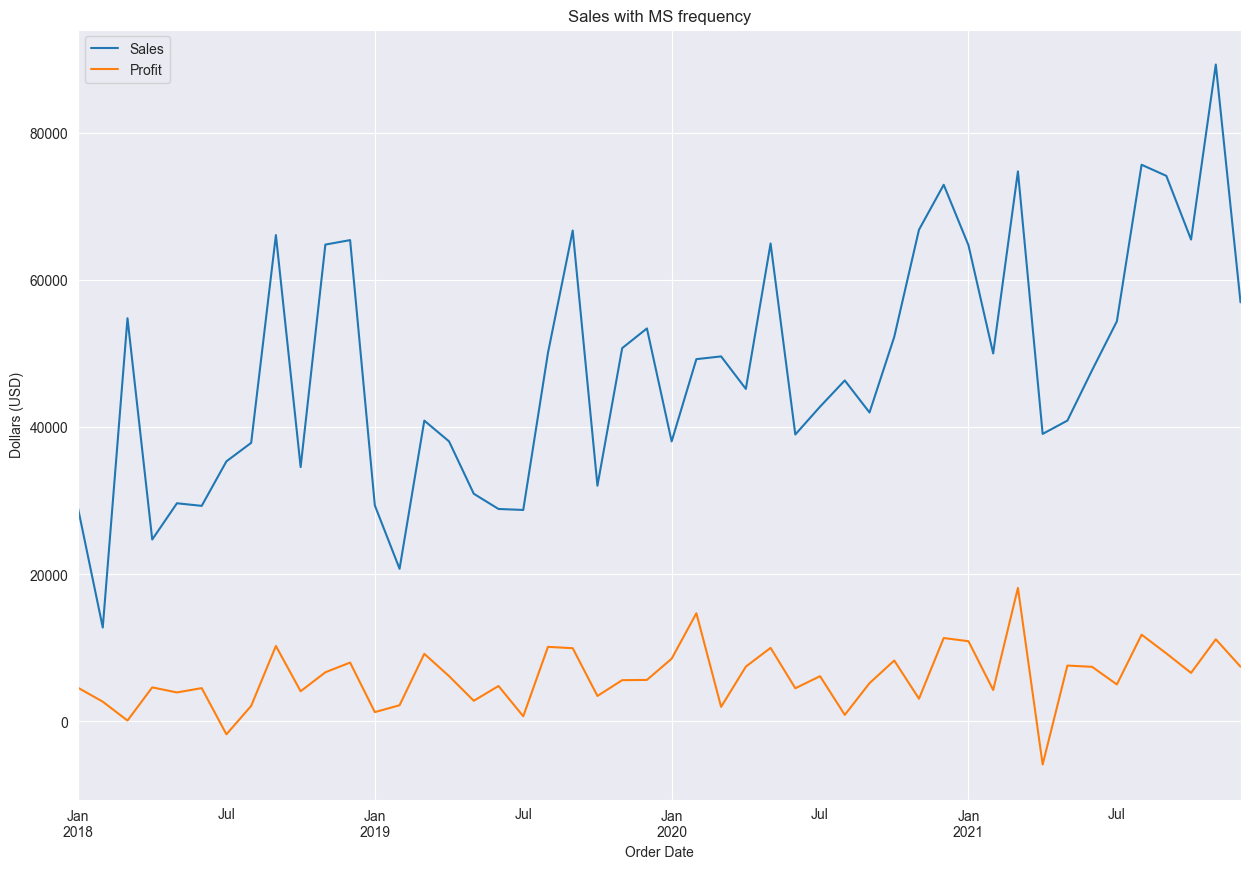

In [36]:
monthly_sales = sales.groupby(pd.Grouper(freq='MS')).sum()
monthly_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales with MS frequency")
plt.ylabel("Dollars (USD)")
plt.show()

In [37]:
yearly_sales = sales.groupby(pd.Grouper(freq='YS')).sum()
yearly_sales

,Sales,Profit
Order Date,,
2018-01-01,484247.4981,49543.9741
2019-01-01,470532.5090,61618.6037
2020-01-01,609205.5980,81795.1743
2021-01-01,733215.2552,93439.2696


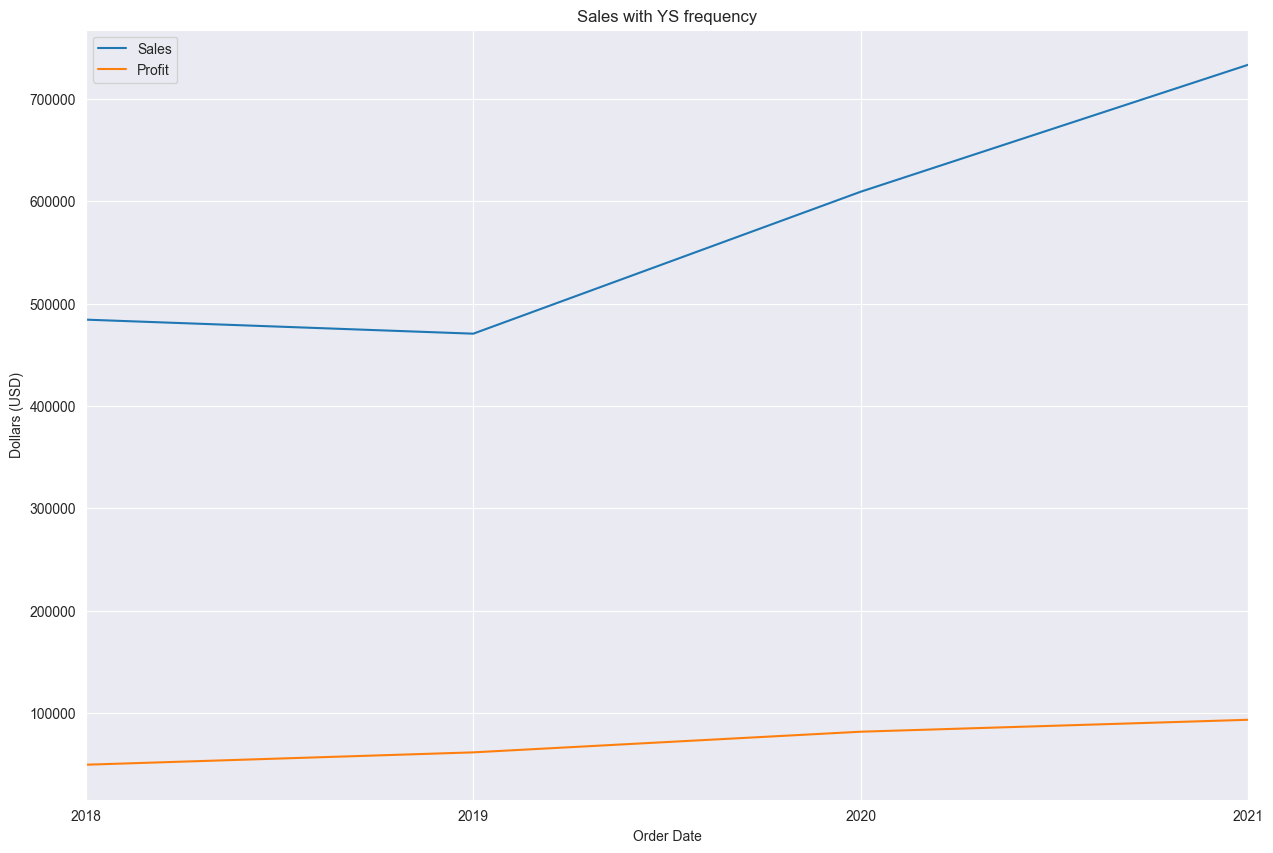

In [38]:
yearly_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales with YS frequency")
plt.ylabel("Dollars (USD)")
plt.show()

In [39]:
#Create empty dataframe to store yearly data
monthly_sales_by_year = pd.DataFrame()

for year in ["2018", "2019", "2020", "2021"]:
    temp_year = monthly_sales.loc[year, ["Sales"]].reset_index(drop = True)
    temp_year.rename(columns={"Sales": year}, inplace = True)
    monthly_sales_by_year = pd.concat([monthly_sales_by_year, temp_year], axis=1)

monthly_sales_by_year

,2018,2019,2020,2021
0,28953.7060,29347.3864,38048.1840,64734.3110
1,12743.1080,20728.3520,49238.4100,50011.4894
2,54801.9060,40876.6112,49612.0450,74774.0838
3,24710.0160,38056.9685,45192.2780,39072.0016
4,29639.8340,30933.7145,64964.3218,40882.4464
5,29287.0306,28862.1982,38991.9430,47742.3255
6,35341.2460,28730.3760,42773.3950,54382.0875
7,37854.5475,50094.5280,46339.9884,75675.3040
8,66110.2238,66729.3290,41985.1423,74164.6080
9,34561.9470,32025.0750,52268.1500,65501.1622


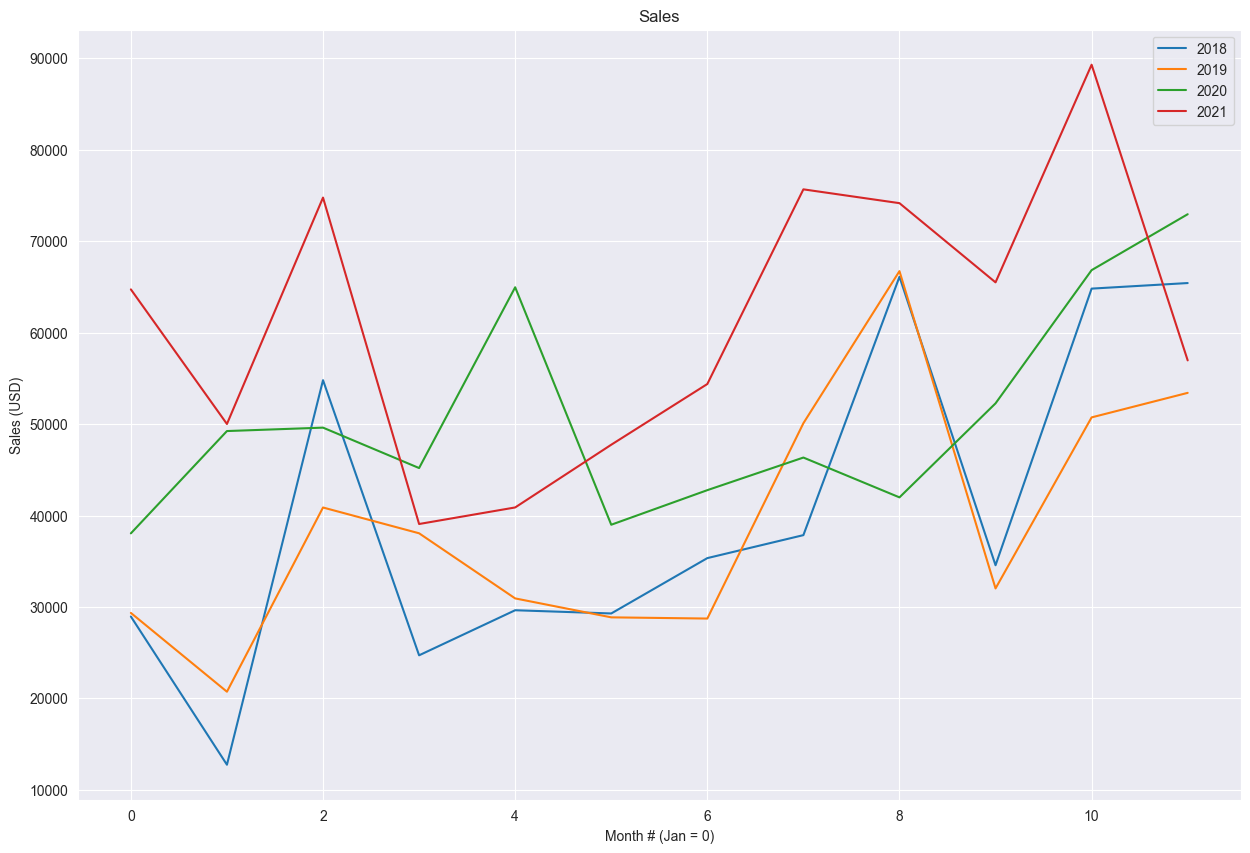

In [40]:
monthly_sales_by_year.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales")
plt.ylabel("Sales (USD)")
plt.xlabel("Month # (Jan = 0)")
plt.show()

In [41]:
sales['30D_sales'] = sales.Sales.rolling(30).mean()
sales['30D_profit'] = sales.Profit.rolling(30).mean()

sns.lineplot(x = sales.index, y = '30D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '30D_profit', data = sales, label = 'Profit')

plt.title("Rolling 30-day Averages of Sales and Profit")
plt.gcf().set_size_inches(15, 5)
plt.ylabel("Dollars (USD)")
plt.show()

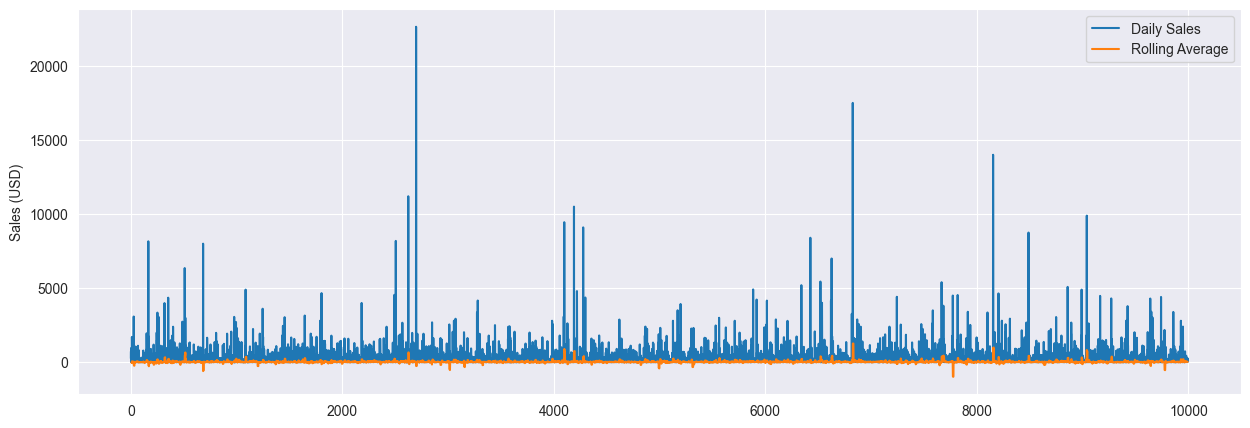

In [45]:
sales['365D_sales'] = sales.Sales.rolling(365).mean()
sales['365D_profit'] = sales.Profit.rolling(365).mean()
sales

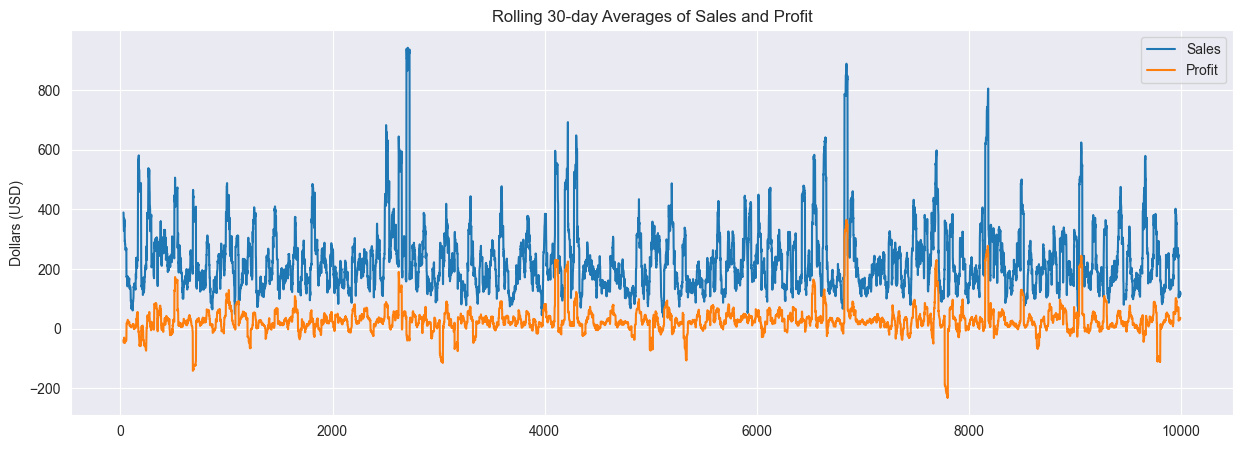

In [44]:
fig, axes = plt.subplots(1, 2)
sales = sales.reset_index(drop=True)
sns.lineplot(ax = axes[0], x = sales.index, y = '365D_sales', data = sales, label = 'Sales', )
sns.lineplot(ax = axes[1], x = sales.index, y = '365D_profit', data = sales, label = 'Profit', palette='r')

fig.suptitle('Rolling Average Year-wise')
plt.gcf().set_size_inches(30, 5)
plt.subplots_adjust(hspace=0.5)
axes[0].set_title('Sales')
axes[1].set_title('Profit')
axes[0].set_ylabel("Sales (USD)")
axes[1].set_ylabel("Profit (USD)")
plt.show()

In [49]:
fig, axes = plt.subplots(1, 2)
sales['percent_sales_yearly'] = sales['365D_sales'].pct_change(periods = 360).mul(100)
sales['percent_profit_yearly'] = sales['365D_profit'].pct_change(periods = 360).mul(100)
sns.lineplot(ax = axes[0], x = sales.index, y = 'percent_sales_yearly', data = sales)
sns.lineplot(ax = axes[1], x = sales.index, y = 'percent_profit_yearly', data = sales)

fig.suptitle('Average Percent Change')
plt.gcf().set_size_inches(30, 5)
plt.subplots_adjust(hspace=0.5)
axes[0].set_title('Sales')
axes[1].set_title('Profit')
axes[0].set_ylabel("Sales (USD)")
axes[1].set_ylabel("Profit (USD)")
plt.show()

,Sales,Profit,7D_sales,7D_profit,30D_sales,30D_profit,365D_sales,365D_profit
0,261.9600,41.9136,NaN,NaN,NaN,NaN,NaN,NaN
1,731.9400,219.5820,NaN,NaN,NaN,NaN,NaN,NaN
2,14.6200,6.8714,NaN,NaN,NaN,NaN,NaN,NaN
3,957.5775,-383.0310,NaN,NaN,NaN,NaN,NaN,NaN
4,22.3680,2.5164,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9989,25.2480,4.1028,76.094000,23.206486,115.110520,31.490800,231.797688,21.577765
9990,91.9600,15.6332,75.234000,21.520600,117.575853,31.903907,230.926347,21.884898
9991,258.5760,19.3932,107.673429,22.131057,124.008920,31.757873,231.609438,21.928845
9992,29.6000,13.3200,103.959143,21.730486,112.213400,34.457553,231.650342,21.946850


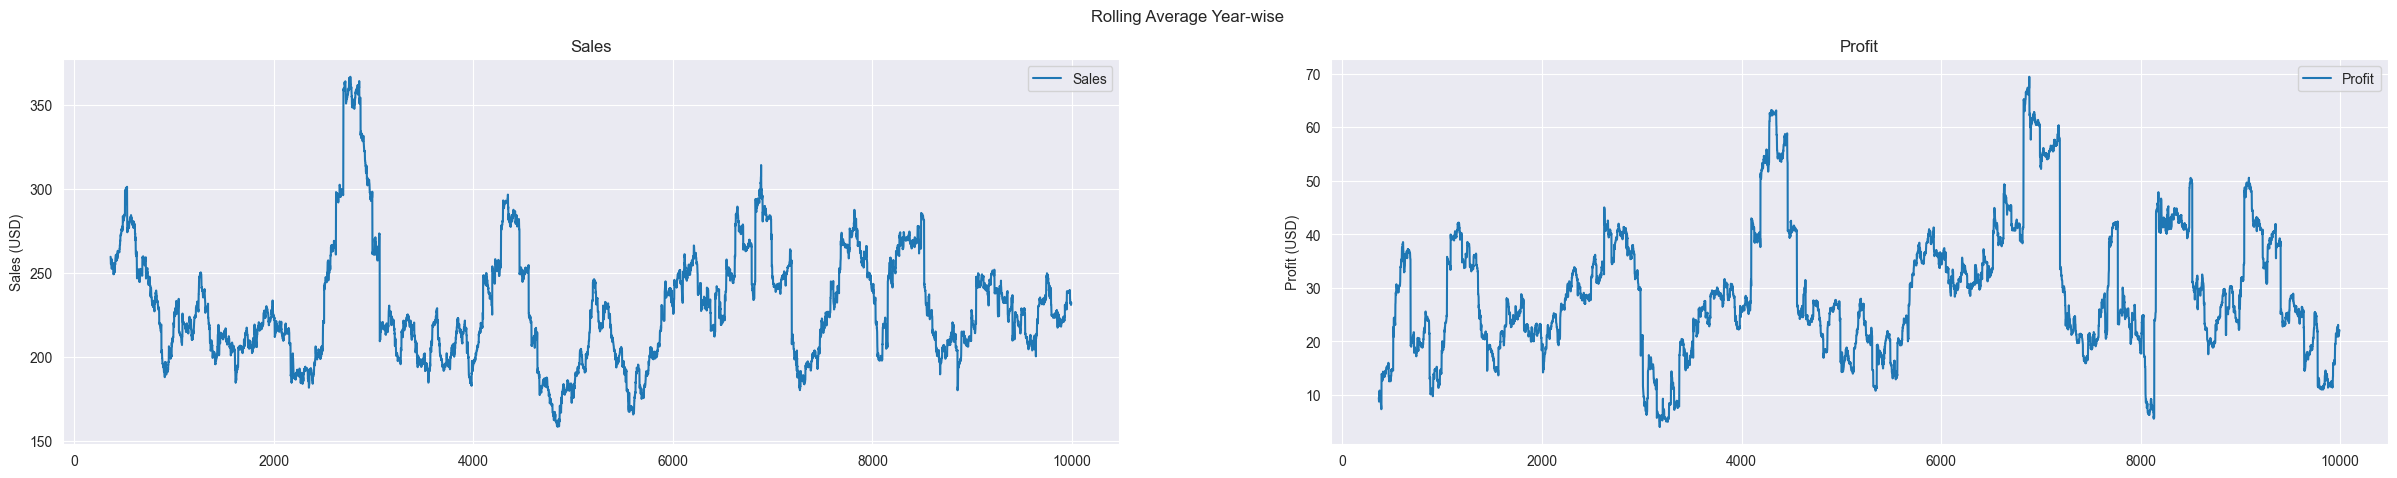

In [50]:
plt.scatter(sales["Sales"], sales["Profit"])
plt.xlabel("Sales (USD)")
plt.ylabel("Profit (USD)")
plt.gcf().set_size_inches(15, 10)
plt.show()

As the rolling average gets larger, the correlation between sales and profits is difficult to predict.

ARIMA: Manual Configuration

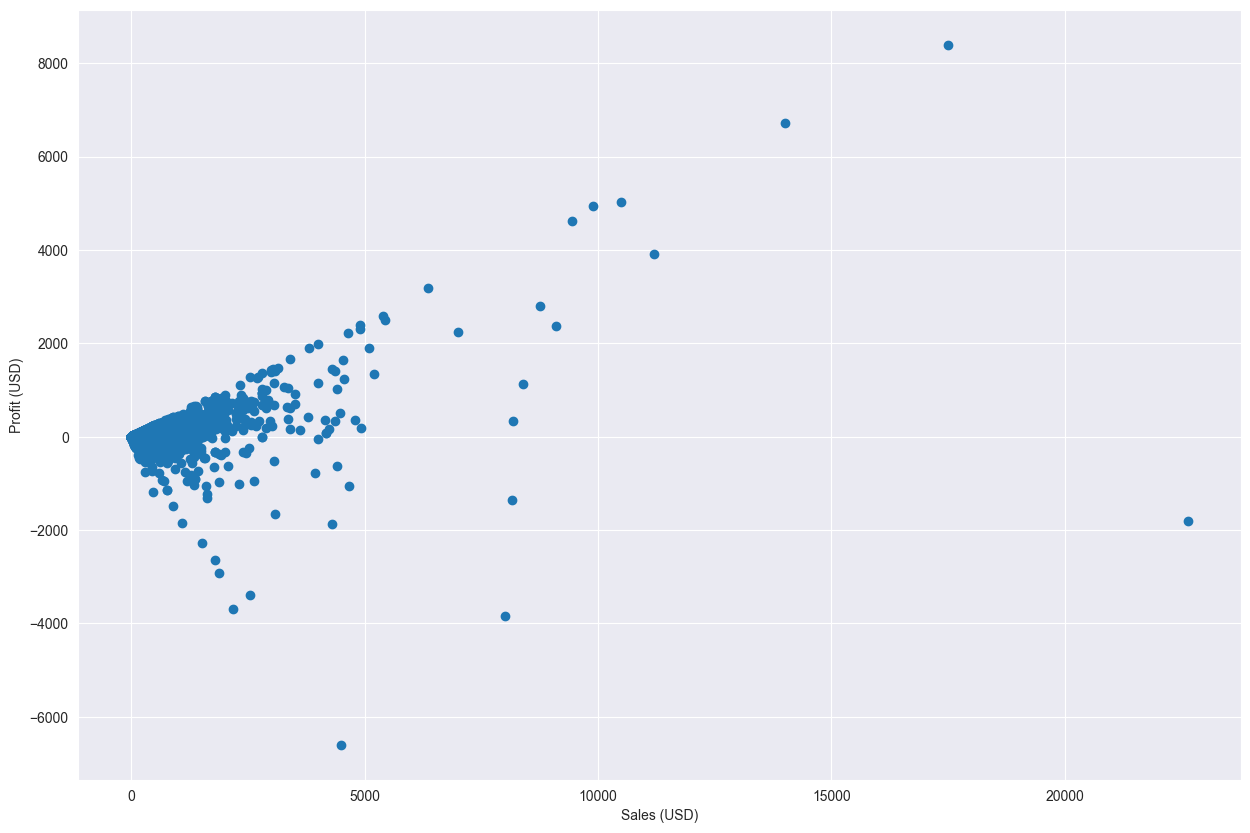

In [48]:
# Create Training and Test
train = monthly_sales[["Sales"]][:36]
test = monthly_sales[["Sales"]][36:]

# copying datasets for final predictions
train_predict = train.copy()
test_predict = test.copy()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_sales["Sales"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('lags: %f' % result[2])
for key,value in result[4].items():
    print(f" critical value {key} : {value}")

In [ ]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2)

#create plot
axes[0, 0].plot(train["Sales"]); axes[0, 0].set_title('Original Series')
plot_acf(train["Sales"], ax=axes[0, 1], title=" Autocorrelation");
axes[1, 0].plot(train["Sales"].diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train["Sales"].diff().dropna(), ax=axes[1, 1], title="Autocorrelation");
axes[2, 0].plot(train["Sales"].diff().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train["Sales"].diff().diff().dropna(), ax=axes[2, 1], title="Autocorrelation");

#visuals
fig.suptitle('Autocorrelation using 30D Rolling Average', weight='bold')
axes[0,0].set_ylabel("Sales (USD)")
axes[1,0].set_ylabel("")
axes[2,0].set_ylabel("")
axes[0,1].set_xticks([])
axes[1,1].set_xticks([])
axes[2,1].set_xticks([])
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(hspace=.5)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

#create figures
fig, axes = plt.subplots(1, 2)
axes[0].plot(train["Sales"].diff()); axes[0].set_title('1st Differencing')
plot_pacf(train["Sales"].diff().dropna(), ax=axes[1])

#visuals
plt.gcf().set_size_inches(30, 10)
plt.xticks([])
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(train["Sales"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train["Sales"].diff().dropna(), ax=axes[1])
plt.gcf().set_size_inches(30, 10)
axes[1].set_xticks([])
plt.show()


In [ ]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Order=(p, d, q)
model = sm.tsa.arima.ARIMA(train["Sales"], order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

#Import the test data, format as an array
validation = test_predict
y = validation.values.astype('float32')

#Import the training data, format as an array
dataset = train_predict
X = dataset.values.astype('float32')

history = [x for x in X] # Create a list of all training data
months_in_year = 12
predictions=list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(y[0])
history.append(y[0])
# first month's performance
print('Predicted: %.3f, Expected: %.3f' % (yhat, y[0]))
#loop through all months and calculate performance
for i in range(1, len(y)):
    months_in_year = 12
    diff = difference(history, months_in_year) #account for seasonality
    model = sm.tsa.arima.ARIMA(diff, order=(2, 1, 0)) #create ARIMA model
    model_fit = model.fit() #fit model
    yhat = model_fit.forecast()[0] #get prediction value
    yhat = inverse_difference(history, yhat, months_in_year) #reverse the difference to get value
    predictions.append(yhat) #add predicted value to list
    # observation
    obs = y[i]
    history.append(obs)
    print('Predicted: %.3f, Expected: %.3f' % (yhat, obs))

# report performance
rmse = np.sqrt(mean_squared_error(y, predictions))
print('\nRMSE: %.3f' %rmse)

In [ ]:
#plot actual versus forecast
plt.plot(y, label="Actual")
plt.plot(predictions, color='red', label="Prediction")

#visuals
plt.title("Sales Predictions for 2022")
plt.xlabel("Months in 2022")
labels=["Jan", "Feb", "Mar", "Apr", "May", "June",
        "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
plt.xticks(ticks=np.arange(0,12,1), labels=labels)
plt.ylabel("Sales (USD)")
plt.gcf().set_size_inches(15, 10)
plt.legend(loc="upper left")
plt.show()